# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- update distance between 2 ghost spots to consider flux and size

## Notes
- for each optical element: 3 rotations, 3 positions
- L1, L2, L3, Filter, Detector, Beam: 6 x 6 = 36 parameters


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0

Direct path is number 15
  central impact point is (0.099736, -0.000019)
  transmission is 0.8681

Maximum expected flux is 0.8681
Maximum bin content is 595.8279


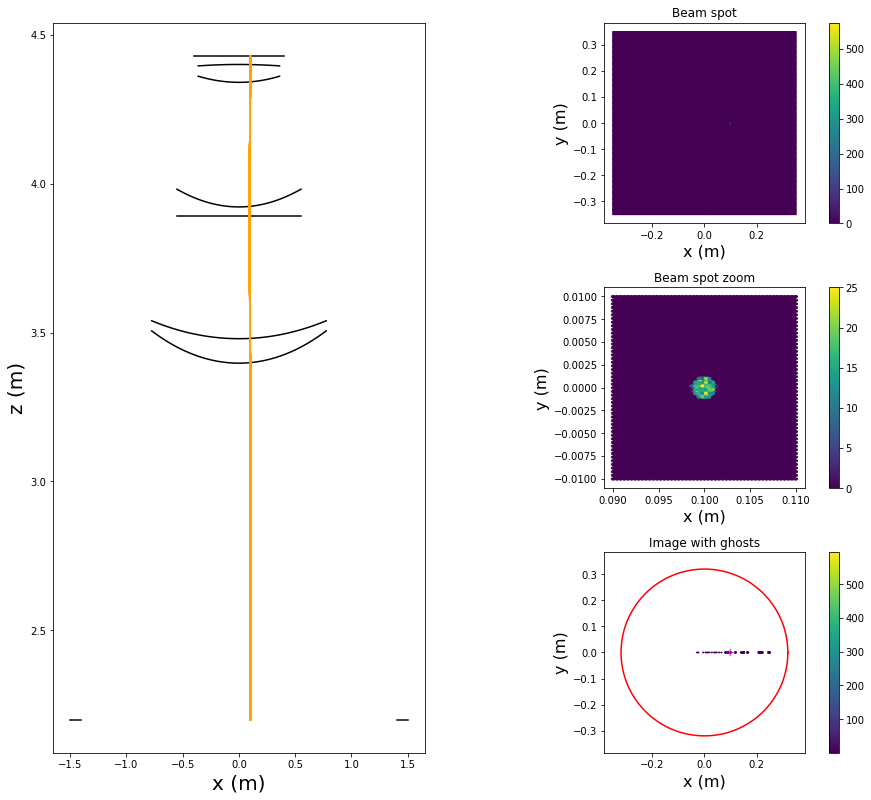

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


(<Figure size 1296x432 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Beam spot'}>,
        <AxesSubplot:title={'center':'Projection of ghosts image on the x-axis'}, xlabel='position x (m)', ylabel='~n photons'>],
       dtype=object))

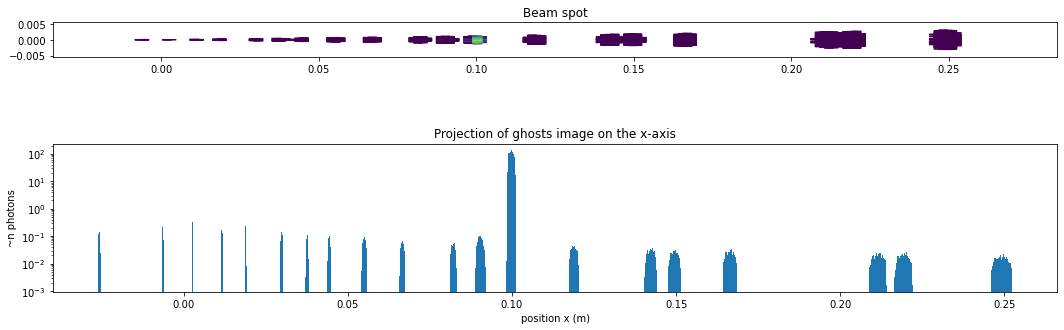

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


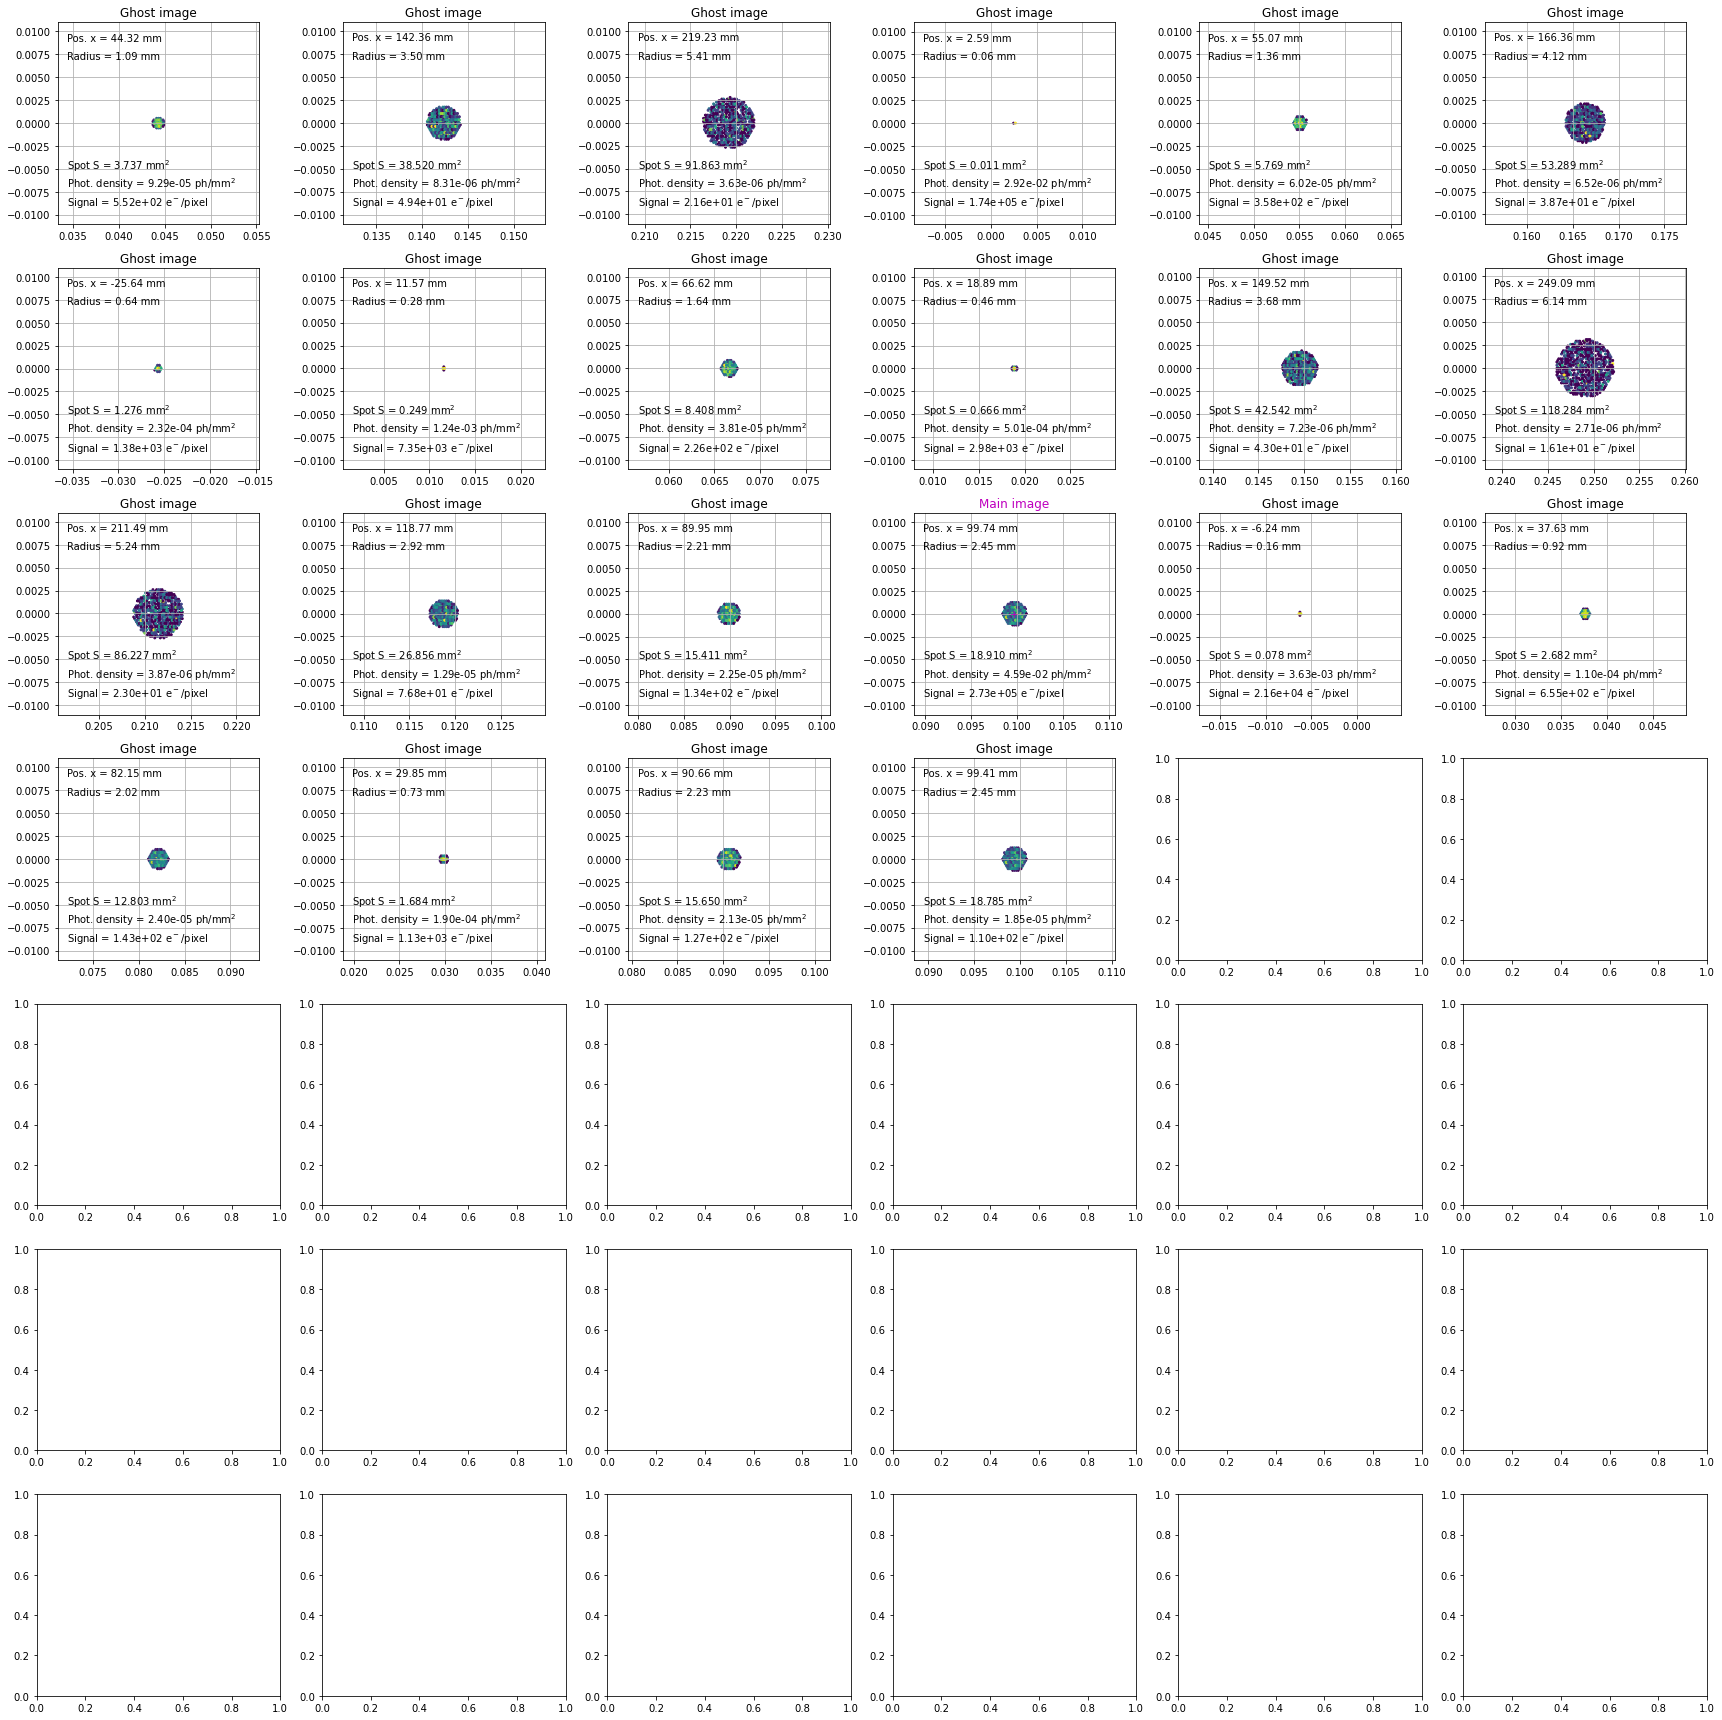

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'])
data_frame_1.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
16,1,0,16,"(Detector, L1_entrance)",-0.006245,0.000041,1.201232e-06,0.000041,0.000162,0.000154,0.000158,4.060182e-06,0.283729,0.078158,21574.467418
17,1,0,17,"(Detector, L1_exit)",0.037626,0.000235,-7.238398e-06,0.000235,0.000922,0.000926,0.000924,1.860228e-06,0.295428,2.682065,654.623401
18,1,0,18,"(Detector, L2_entrance)",0.082145,0.000513,-1.580303e-05,0.000513,0.002016,0.002021,0.002019,2.574058e-06,0.307609,12.802905,142.790774
19,1,0,19,"(Detector, L2_exit)",0.029849,0.000186,-5.742409e-06,0.000186,0.000730,0.000734,0.000732,2.232148e-06,0.320293,1.684500,1130.018658
20,1,0,20,"(Detector, L3_entrance)",0.090664,0.000569,-1.744188e-05,0.000569,0.002233,0.002231,0.002232,9.926318e-07,0.333499,15.650055,126.645135
21,1,0,21,"(Detector, L3_exit)",0.099412,0.000622,-1.912473e-05,0.000622,0.002444,0.002446,0.002445,8.685213e-07,0.347250,18.785450,109.857729
0,1,0,0,"(L1_exit, L1_entrance)",0.044316,0.000278,-8.525526e-06,0.000278,0.001091,0.001090,0.001091,2.416995e-07,0.347250,3.737463,552.173184
3,1,0,3,"(L2_entrance, L1_entrance)",0.002586,0.000015,-4.975095e-07,0.000015,0.000057,0.000064,0.000060,3.320157e-06,0.333499,0.011422,173527.541029
4,1,0,4,"(L2_entrance, L1_exit)",0.055066,0.000345,-1.059350e-05,0.000345,0.001355,0.001355,0.001355,1.506468e-07,0.347250,5.769222,357.713172
1,1,0,1,"(L2_exit, L1_entrance)",0.142360,0.000891,-2.738711e-05,0.000891,0.003500,0.003503,0.003502,1.382162e-06,0.320293,38.520224,49.416014


Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


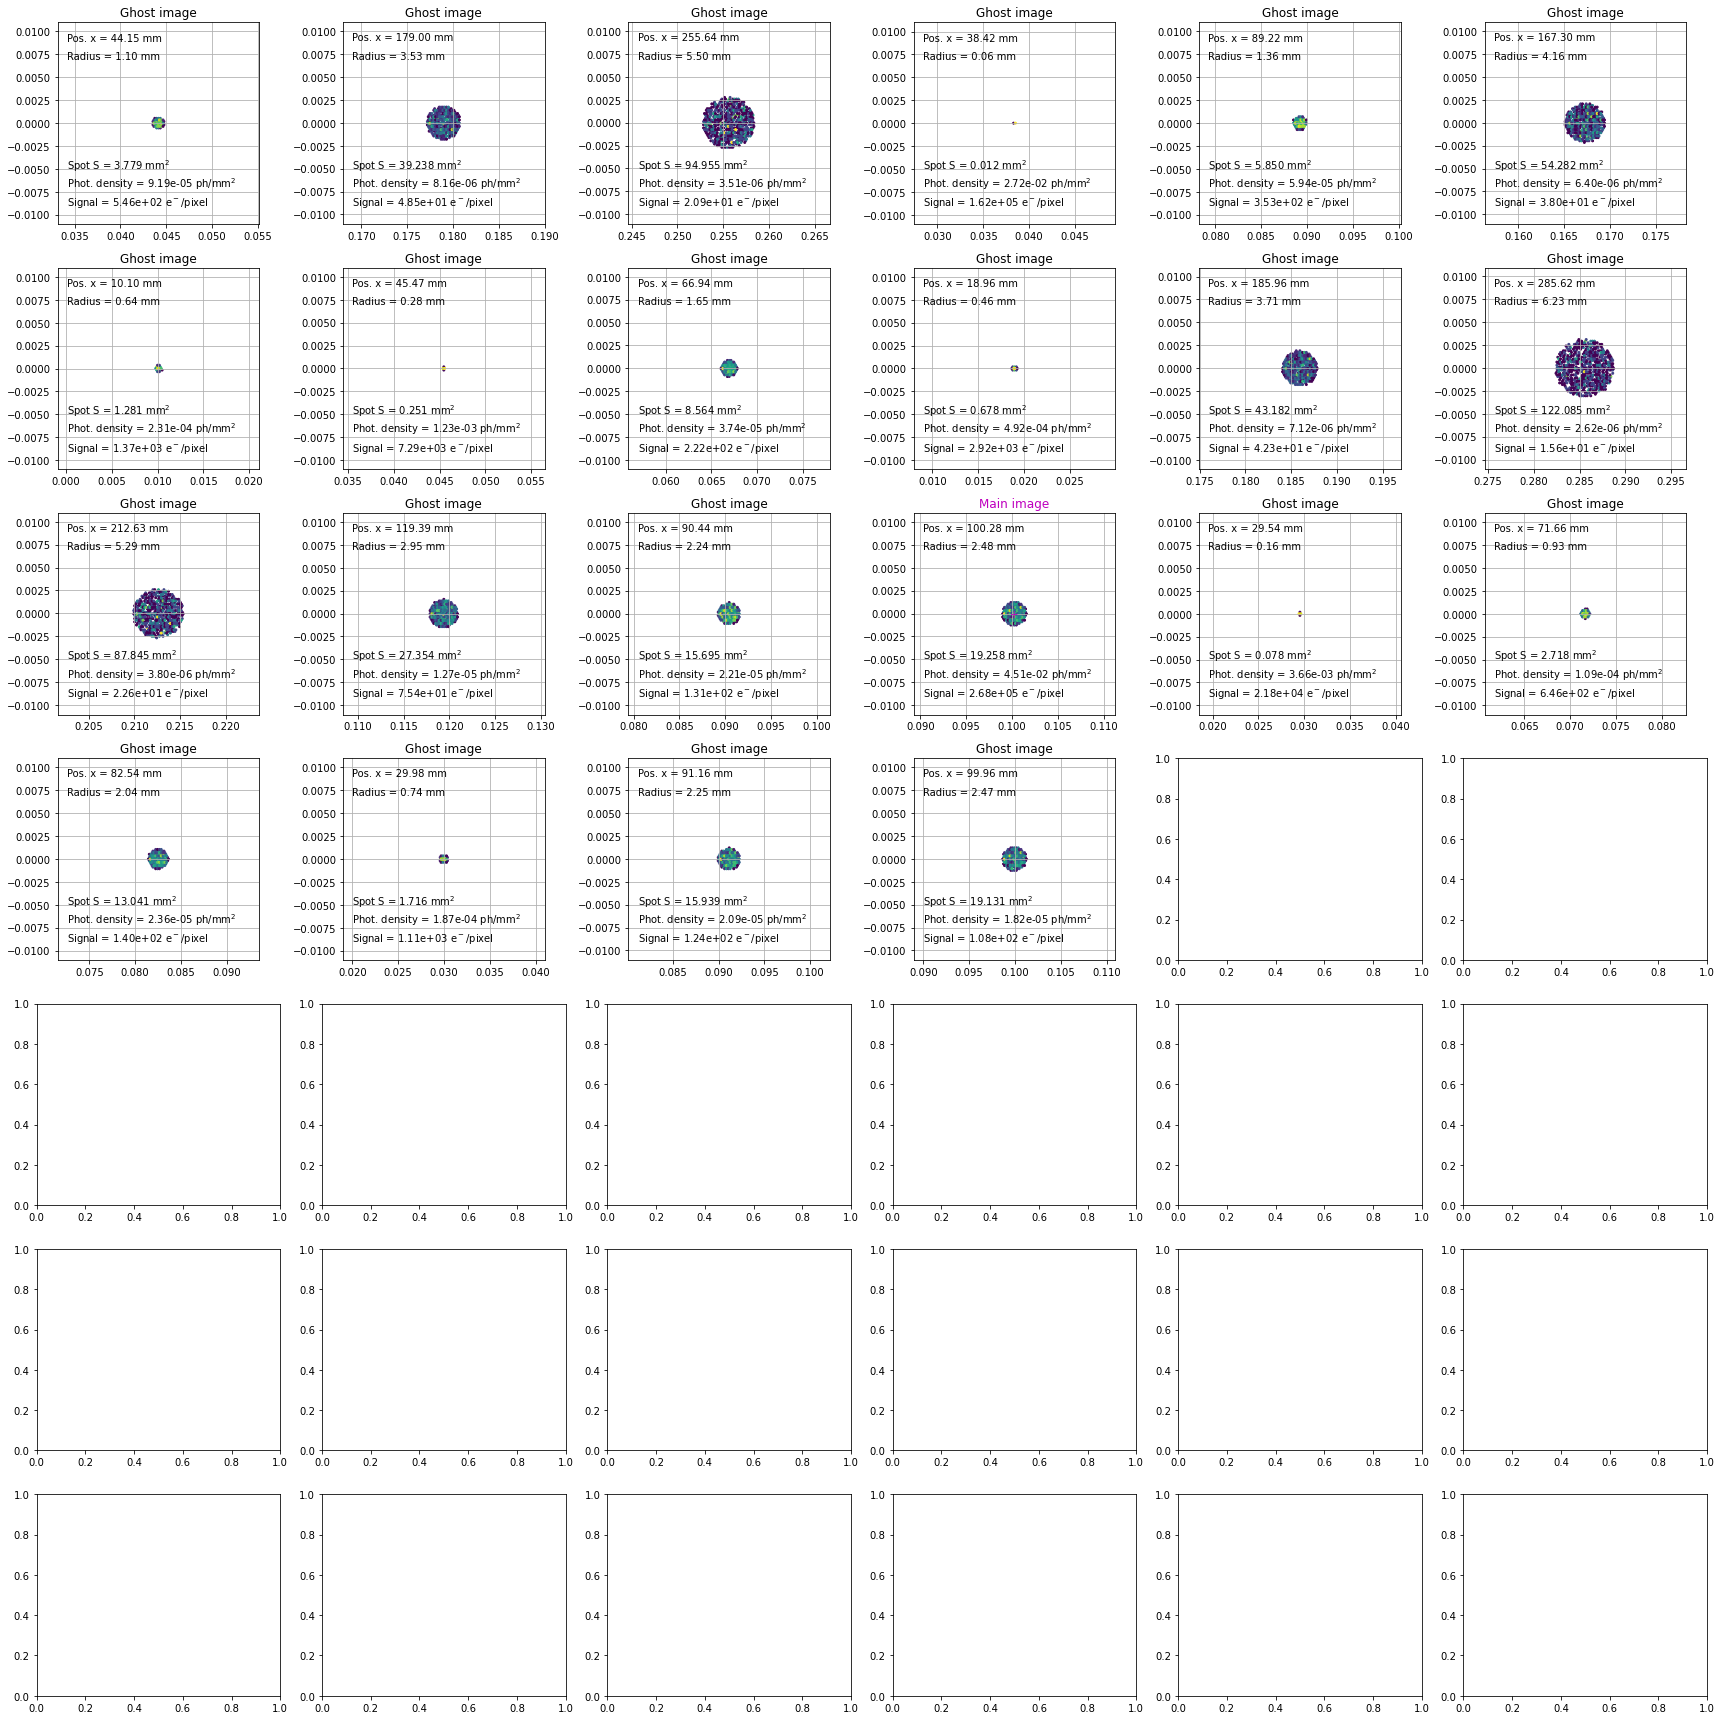

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1['beam_id'])
data_frame_2.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
16,1,0,16,"(Detector, L1_entrance)",0.029543,0.000041,1.489605e-06,0.000041,0.000160,0.000154,0.000157,2.957651e-06,0.283729,0.077505,21756.238451
17,1,0,17,"(Detector, L1_exit)",0.071659,0.000237,-8.999093e-06,0.000237,0.000929,0.000931,0.000930,7.664090e-07,0.295428,2.718375,645.879460
18,1,0,18,"(Detector, L2_entrance)",0.082544,0.000520,-1.968207e-05,0.000520,0.002039,0.002036,0.002037,1.242079e-06,0.307609,13.040707,140.186935
19,1,0,19,"(Detector, L2_exit)",0.029977,0.000188,-7.152182e-06,0.000188,0.000738,0.000740,0.000739,8.430164e-07,0.320293,1.715984,1109.285314
20,1,0,20,"(Detector, L3_entrance)",0.091158,0.000576,-2.172235e-05,0.000576,0.002258,0.002247,0.002252,5.185933e-06,0.333499,15.938574,124.352612
21,1,0,21,"(Detector, L3_exit)",0.099956,0.000630,-2.381792e-05,0.000630,0.002471,0.002464,0.002468,3.674421e-06,0.347250,19.130829,107.874406
0,1,0,0,"(L1_exit, L1_entrance)",0.044149,0.000280,-1.059675e-05,0.000280,0.001097,0.001096,0.001097,5.045236e-07,0.347250,3.778996,546.104585
3,1,0,3,"(L2_entrance, L1_entrance)",0.038417,0.000015,-6.223669e-07,0.000015,0.000060,0.000064,0.000062,1.951309e-06,0.333499,0.012244,161880.529155
4,1,0,4,"(L2_entrance, L1_exit)",0.089223,0.000348,-1.317371e-05,0.000348,0.001366,0.001363,0.001365,1.756456e-06,0.347250,5.850143,352.765196
1,1,0,1,"(L2_exit, L1_entrance)",0.179003,0.000902,-3.413421e-05,0.000902,0.003537,0.003531,0.003534,2.810194e-06,0.320293,39.237662,48.512471


In [12]:
match_1_2 = match_ghosts(data_frame_1, data_frame_2)
match_1_2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,1,0,1,0,0,0,0.000168,0.000558,0,0.000627,0.000560
1,1,0,1,0,1,13,0.022969,0.001651,1,0.036786,0.001820
2,1,0,1,0,2,12,0.006606,0.002740,12,0.013663,0.005462
3,1,0,1,0,3,6,0.007515,0.000233,16,0.028641,0.000449
4,1,0,1,0,4,7,0.009597,0.000498,0,0.028049,0.000630
5,1,0,1,0,5,5,0.000940,0.002123,5,0.003934,0.004656
6,1,0,1,0,6,6,0.035737,0.000328,6,0.035737,0.000884
7,1,0,1,0,7,6,0.001473,0.000253,9,0.019757,0.000531
8,1,0,1,0,8,8,0.000315,0.000836,8,0.001545,0.000907
9,1,0,1,0,9,9,0.000067,0.000234,9,0.000432,0.000620


In [13]:
compute_reduced_distance(match_1_2)

0.004315917480806664

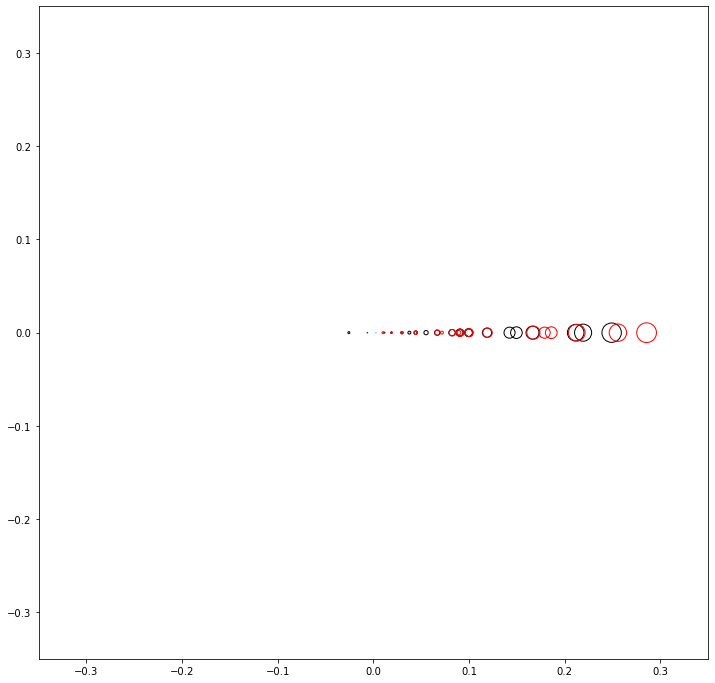

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [15]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance 3d = 0.00804
distance 2d = 0.00508


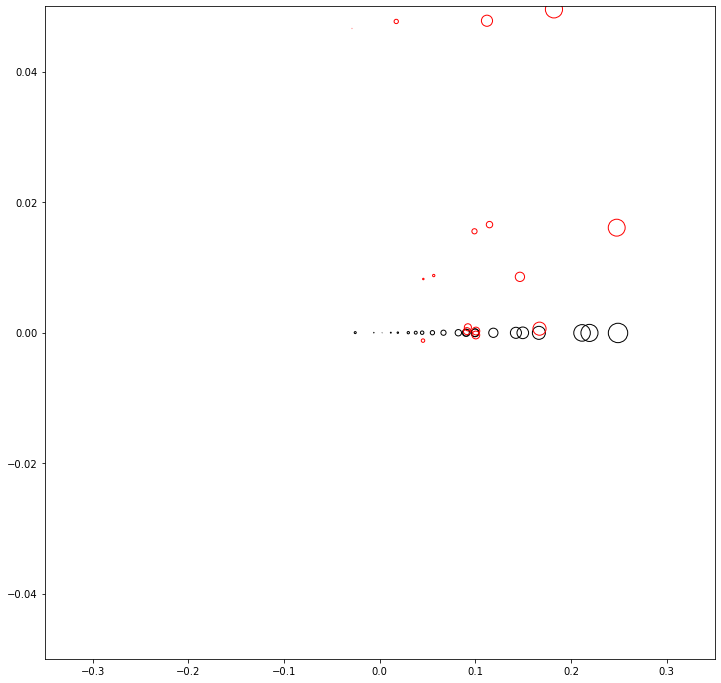

In [16]:
match_1_r = match_ghosts(data_frame_1, data_frame_r)
dist_1_r = compute_reduced_distance(match_1_r)
print(f'distance 3d = {dist_1_r:.5f}')
dist_1_r_2d = compute_2d_reduced_distance(match_1_r)
print(f'distance 2d = {dist_1_r_2d:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [17]:
# See what happens with a random telescope
data_frame_r2, ghost_separations_r2 = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.01017


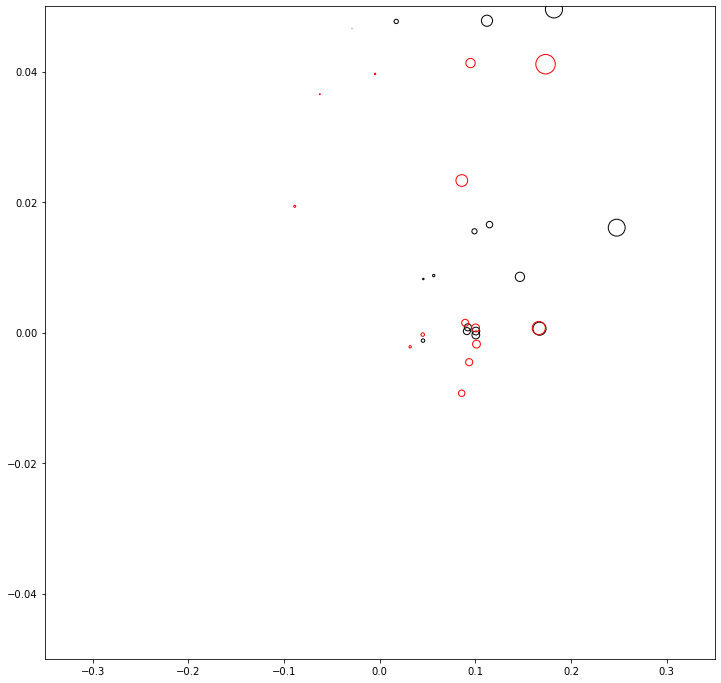

In [18]:
match_r_r2 = match_ghosts(data_frame_r, data_frame_r2)
dist_r_r2 = compute_reduced_distance(match_r_r2)
print(f'distance = {dist_r_r2:.5f}')
fig, ax = plotter.plot_spots([data_frame_r, data_frame_r2], range_y=(-0.05, 0.05))


In [19]:
match_r_r2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,0,0,0,0,0,0,0.000971,0.000565,0,0.001179,0.000823
1,0,0,0,0,1,13,0.018375,0.001665,10,0.041025,0.003075
2,0,0,0,0,2,12,0.006752,0.002746,12,0.017629,0.004166
3,0,0,0,0,3,9,0.025133,0.000166,7,0.041917,0.000755
4,0,0,0,0,4,8,0.016271,0.000778,8,0.033562,0.001497
5,0,0,0,0,5,5,0.000766,0.002144,5,0.001670,0.002362
6,0,0,0,0,6,9,0.019569,0.000286,9,0.026904,0.000870
7,0,0,0,0,7,8,0.017844,0.000611,9,0.056539,0.001033
8,0,0,0,0,8,15,0.014860,0.001079,18,0.048849,0.001812
9,0,0,0,0,9,0,0.008543,0.000436,19,0.032413,0.000793


In [20]:
distances_2d = list()
distances_3d = list()
for i in range(10):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.001, beam_config=FAST_BEAM_CONFIG_1)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances_3d.append(dist_i)
    
    match_i2 = match_ghosts(data_frame_1, df_i)
    dist_i2 = compute_2d_reduced_distance(match_i2)
    distances_2d.append(dist_i2)


(array([1., 0., 0., 1., 1., 1., 0., 2., 1., 3.]),
 array([0.00191483, 0.00211105, 0.00230728, 0.0025035 , 0.00269973,
        0.00289595, 0.00309218, 0.0032884 , 0.00348463, 0.00368085,
        0.00387708]),
 <BarContainer object of 10 artists>)

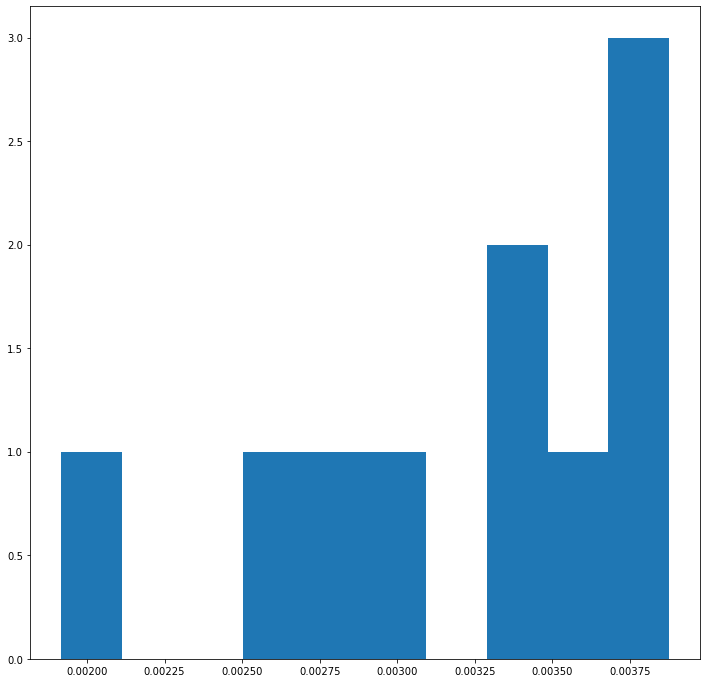

In [21]:
plt.hist(distances_2d)
# plt.xlim(0., 0.010)

(array([1., 1., 0., 3., 1., 1., 1., 0., 1., 1.]),
 array([0.01027977, 0.01093151, 0.01158326, 0.01223501, 0.01288675,
        0.0135385 , 0.01419024, 0.01484199, 0.01549373, 0.01614548,
        0.01679723]),
 <BarContainer object of 10 artists>)

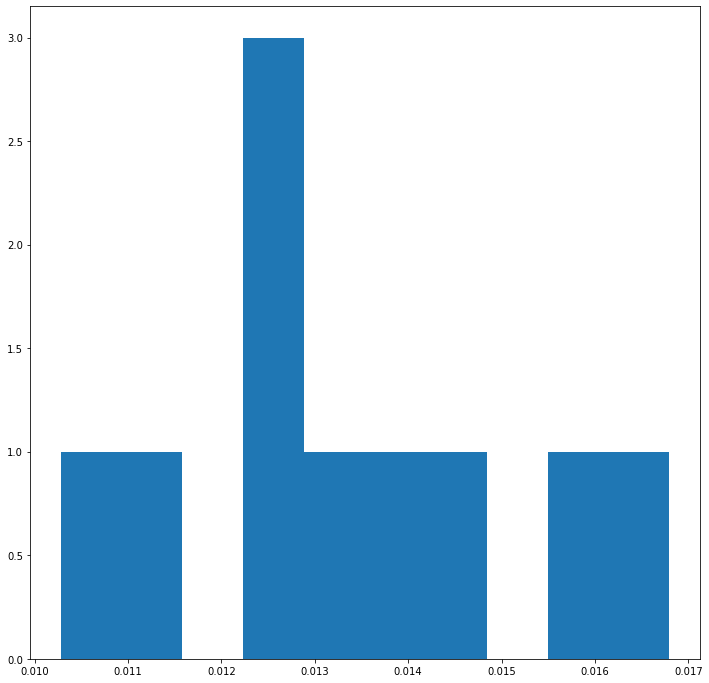

In [22]:
plt.hist(distances_3d)
